In [3]:
#Load packages
from netCDF4 import Dataset
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import sys
import netCDF4 as nc4
sys.path.append("../TRAINING")
from CNN_tools import *
from CNN_UNET import *
from pytorch_lightning.callbacks import ModelCheckpoint
from variables import *
from tools_analyse import *
import importlib
import numpy as np
import os

#Module CROCO
from Modules import *


def create_proba_dynamics(lim_inf,nb_step,dx,var_mean,index_non_valid,coef):
    list_proba_var = []
    list_nb_cases_var = []
    list_xticks = []
    
    lim_sup = lim_inf+dx
    
    index_var = np.argwhere((var_mean[:-36] < lim_inf))
    Proba_nv_var = (np.sum(index_non_valid[index_var])) / index_var.shape[0]
    list_proba_var.append(Proba_nv_var)
    list_nb_cases_var.append(index_var.shape[0])
    if lim_inf*coef > 10:      
        list_xticks.append(' < '+ f'{(lim_inf*coef):.0f}' )
    else : 
        list_xticks.append(' < '+ f'{(lim_inf*coef):.1f}' )
        
    for i in range(nb_step):
        if i>0:
            lim_inf = lim_inf + dx
            lim_sup = lim_sup + dx

        index_var = np.argwhere((var_mean[:-36] < lim_sup) & (var_mean[:-36] > lim_inf))
        Proba_nv_var = (np.sum(index_non_valid[index_var])) / index_var.shape[0]
        list_proba_var.append(Proba_nv_var)
        list_nb_cases_var.append(index_var.shape[0])
        #list_xticks.append(f'{lim_inf*coef:.1f}'+' - '+ f'{lim_sup*coef:.1f}')
        if lim_inf*coef > 10:      
            list_xticks.append(f'{(lim_inf+lim_sup)/2*coef:.0f}')
        else:
            list_xticks.append(f'{(lim_inf+lim_sup)/2*coef:.1f}')
    
    index_var = np.argwhere((var_mean[:-36] > lim_sup))
    Proba_nv_var = (np.sum(index_non_valid[index_var])) / index_var.shape[0]
    list_proba_var.append(Proba_nv_var)
    list_nb_cases_var.append(index_var.shape[0])
    
    if lim_inf*coef > 10:      
        list_xticks.append(' < '+ f'{(lim_sup*coef):.0f}' )
    else:
        list_xticks.append(' > '+ f'{lim_sup*coef:.1f}')
    
    return(list_proba_var,list_nb_cases_var,list_xticks)

def plot_bar_chart(list_xticks,nv_var,nv_var_4L,nb_var,var_str,ax):

    n_xticks = len(list_xticks)
    window = (float(list_xticks[2])-float(list_xticks[1]))/2
    plt.xticks(size=20)
    plt.yticks(size=20)
    #if 'pdf' not in var_str:
    plt.ylabel('Fraction of $BL_{200m} > 0.2 $',size=20)
    #plt.grid()
    labelpad = -17
    if 'ow' in var_str:
        plt.xlabel('OW /$f^{2}$ [$x10^{-3}$]'+' +/- {0:.1f}'.format(window) ,size=20,labelpad=labelpad)
    elif 'vrt' in var_str:
        plt.xlabel('$\zeta$ /$f$ [$x10^{-2}$]'+' +/- {0:.1f}'.format(window),size=20,labelpad=labelpad)
    elif 'sla' in var_str : 
        plt.xlabel('SLA [$x10^{-1}$]'+' +/- {0:.1f}'.format(window),size=20,labelpad=labelpad)
    elif 'mc' in var_str : 
        plt.xlabel('mass center [km]'+' +/- {0:.1f}'.format(window),size=20,labelpad=labelpad)
    elif 'var' in var_str : 
        plt.xlabel('Variance [x $10^4$ $km^2$]'+' +/- {0:.1f}'.format(window),size=20,labelpad=labelpad)    

    #elif 'ke' in var_str :  
    #    plt.xlabel('$KE_{600m - 1000m}$ [$cm^2 s^{-2}$] +/- '+str(window),size=20,labelpad=labelpad)

    elif 'eke' in var_str :  
        plt.xlabel('$EKE_{200m - 1000m}$ [$cm^2 s^{-2}$]'+' +/- {0:.1f}'.format(window),size=20,labelpad=labelpad)

    elif 'mke' in var_str :  
        plt.xlabel('$MKE_{200m - 1000m}$ [$cm^2 s^{-2}$]'+' +/- {0:.1f}'.format(window),size=20,labelpad=labelpad)
        
    elif 'entropie' in var_str : 
        plt.xlabel('Entropy'+' +/- {0:.2f}'.format(window),size=20,labelpad=labelpad)
    else : 
        plt.xlabel('STD [$x10^{-5}$]'+' +/- {0:.1f}'.format(window),size=20,labelpad=labelpad)
        
    if "mc" in var_str:
        plt.ylim(0,0.9)
    elif "entropie" in var_str:
        plt.ylim(0,0.9)
    else:
        plt.ylim(0,0.6)
    
    plt.xticks(np.arange(1,n_xticks+1),list_xticks,size=20,rotation=30)
    bar1 = plt.bar(np.arange(1,n_xticks+1),nv_var,alpha=0.8,color ='darkseagreen',label = '$Unet_{surf}$')
    bar2 = plt.bar(np.arange(1,n_xticks+1),nv_var_4L,alpha=0.5, color='firebrick',label = '$Unet_{4layers}$')
    
    if var_str =='pdf_mc': 
        plt.legend(prop={'size': 20},loc=2)
    
    props = dict(boxstyle='round', facecolor='white', alpha=1)

    
# MASSE CENTER MOVEMENT
def masse_center_mov(pdf):
    mx = np.sum(np.multiply(lon,np.sum(pdf,axis=0)))
    my = np.sum(np.multiply(lat,np.sum(pdf,axis=1)))
    return np.sqrt(mx**2 + my**2)

def masse_center_mov_mxy(pdf):
    mx = np.sum(np.multiply(lon,np.sum(pdf,axis=0)))
    my = np.sum(np.multiply(lat,np.sum(pdf,axis=1)))
    return mx,my

# VARIANCE
def variance(pdf):
    D = 0
    mx,my = masse_center_mov_mxy(pdf)
    for i in range(100):
        for j in range(100):
            D = D + (500/499)*pdf[i,j]*((lon[i]-mx)**2+(lat[j]-my)**2)
    return D

lon = np.linspace(-400,400,nb_dx)
lat = np.linspace(-400,400,nb_dx)

# VARIANCE
def entropie(pdf):
    D = 0
    for i in range(100):
        for j in range(100):
            if pdf[i,j]==0:
                 continue
            else:
                D = D - pdf[i,j]*np.log(pdf[i,j])
    return D


def create_proba_dynamics_mld(lim_inf,nb_step,dx,var_mean,index_non_valid,coef):
    
    list_proba_var = []
    list_nb_cases_var = []
    list_xticks = []
    
    lim_sup = lim_inf+dx
    
    index_var = np.argwhere((var_mean[:-36] < lim_inf))
    Proba_nv_var = (np.sum(index_non_valid[index_var])) / index_var.shape[0]
    list_proba_var.append(Proba_nv_var)
    list_nb_cases_var.append(index_var.shape[0])
    list_xticks.append(' < '+ f'{(lim_inf*coef):.1f}' )
    
    for i in range(nb_step):
        if i>0:
            lim_inf = lim_sup
            lim_sup = lim_sup + dx*(i+1)

        index_var = np.argwhere((var_mean[:-36] < lim_sup) & (var_mean[:-36] > lim_inf))
        Proba_nv_var = (np.sum(index_non_valid[index_var])) / index_var.shape[0]
        list_proba_var.append(Proba_nv_var)
        list_nb_cases_var.append(index_var.shape[0])
        #list_xticks.append(f'{lim_inf*coef:.1f}'+' - '+ f'{lim_sup*coef:.1f}')
        list_xticks.append(f'{(lim_inf+lim_sup)/2*coef:.1f}')
    
    index_var = np.argwhere((var_mean[:-36] > lim_sup))
    Proba_nv_var = (np.sum(index_non_valid[index_var])) / index_var.shape[0]
    list_proba_var.append(Proba_nv_var)
    list_nb_cases_var.append(index_var.shape[0])
    list_xticks.append(' > '+ f'{lim_sup*coef:.1f}')
    
    return(list_proba_var,list_nb_cases_var,list_xticks)



# Load data

In [4]:
tstart = 1900
my_simul = 'aperitif_simu2'
str_para = ' [{0},{1},{2},{3},[1,100,1]] '.format(jc-260,jc+260,ic-260,ic+260)
parameters = my_simul +str_para+ format(tstart)
simul = load(simul = parameters, floattype=np.float64, output=False)
f = simul.f

nc = nc4.Dataset('/home2/datawork/tpicard/DATA_CNN/analyse/vrt_ow_strain_mean_100x100_surf_j20.nc','r')
vrt_mean = np.asfortranarray(nc.variables['vrt'])
ow_mean = np.asfortranarray(nc.variables['ow'])/(np.mean(f)**2)
strain_mean = np.asfortranarray(nc.variables['strain'])
nc.close()

nc = nc4.Dataset('/home2/datahome/tpicard/PhD_MOMOPAR/TRAIN_AND_VALIDATION_CNN/OLD/STD_article_4L.nc','r')
std_4L = np.asfortranarray(nc.variables['std'])[:-8]
nc.close()

nc = nc4.Dataset('/home2/datahome/tpicard/PhD_MOMOPAR/TRAIN_AND_VALIDATION_CNN/OLD/STD_article_surf.nc','r')
std_surf = np.asfortranarray(nc.variables['std'])[:-8]
nc.close()

nc = nc4.Dataset('/home2/datawork/tpicard/DATA_CNN/analyse/ssh_mean_60x60_surf.nc','r')
sla_j10 = np.asfortranarray(nc.variables['ssh_j10'])[:-8]
sla_j20 = np.asfortranarray(nc.variables['ssh_j20'])[:-8]
nc.close()


folder = '/home/datawork-lemar-apero/tpicard/EKE/'
name_nc = 'MKE_EKE_box1040km_windows30j_sample20.nc'
file = folder+name_nc
nc = nc4.Dataset(file,'r')
EKE = np.asfortranarray(nc.variables['EKE'][:,:])
KEbar = np.asfortranarray(nc.variables['MKE'][:,:])
date_EKE = np.asfortranarray(nc.variables['time'][:])
nc.close()

level_600 = 12 
level_200 = 4
level = level_200 ## CHOOSE YOUR LEVEL 
KEbar_600_1000_30 = np.nanmean(KEbar[:,level:,:,:],axis=(1))

window = 100+60
def image_selector_1layer(pos,var):
    pos_j = pos%6
    pos_i = pos//6
    d_ic = ic_all_list[pos_i]
    d_jc = jc_all_list[pos_j]
    var = var[window+d_ic:-window+d_ic,window+d_jc:-window+d_jc]

    return(var)

KEbar_pos = np.zeros(EKE.shape[0]*36)

t = 0
#for i in range(190):
for i in range(EKE.shape[0]):
    for pos in range(0,36):
        KE_i = KEbar_600_1000_30[i,:,:]
        KE_box = image_selector_1layer(pos,KE_i)
        KEbar_pos[t] = np.nanmean(KE_box)
        t=t+1
        
print(KEbar_pos.shape)

EKE_200_1000_30 = np.nanmean(EKE[:,level:,:,:],axis=(1))
EKE_pos = np.zeros(KEbar.shape[0]*36)

t = 0
for i in range(KEbar.shape[0]):
    for pos in range(0,36):
        KE_i = EKE_200_1000_30[i,:,:]
        KE_box = image_selector_1layer(pos,KE_i)
        EKE_pos[t] = np.nanmean(KE_box)
        t=t+1
        
print(EKE_pos.shape)

EKE_pos = EKE_pos[:-36*7]
KEbar_pos = KEbar_pos[:-36*7]

#(image_test,pdf_test,pdf_filter_test) = load_data_test_surface_all()
#LOAD super model
nc = nc4.Dataset('/home2/datahome/tpicard/PhD_MOMOPAR/TRAIN_AND_VALIDATION_CNN/OLD/Super_model_all_surface.nc','r')
super_model_surf = np.asfortranarray(nc.variables['super_model_norm'])
nc.close()


pdf_filter_test = load_pdf_filter_simu2()
pdf_filter_test = np.transpose(pdf_filter_test,(0,2,1,3,4))
pdf_filter_test = pdf_filter_test.reshape(pdf_filter_test.shape[0]*pdf_filter_test.shape[1],8,100,100)
pdf_filter_test = pdf_filter_test[:-36]

list_bhatta_surf = np.zeros(pdf_filter_test.shape[0])
for i in range(pdf_filter_test.shape[0]):
    list_bhatta_surf[i] = 1 - np.sum(np.sqrt(np.abs((np.multiply(super_model_surf[i,:,:], pdf_filter_test[i,-1,:,:])))))
    
#(image_test,pdf_test,pdf_filter_test) = load_data_test_surface_all()
#LOAD super model
nc = nc4.Dataset('/home2/datahome/tpicard/PhD_MOMOPAR/TRAIN_AND_VALIDATION_CNN/OLD/Super_model_all_4L.nc','r')
super_model_4L = np.asfortranarray(nc.variables['super_model_norm'])
nc.close()

list_bhatta_4L = np.zeros(pdf_filter_test.shape[0])
for i in range(pdf_filter_test.shape[0]):
    list_bhatta_4L[i] = 1 - np.sum(np.sqrt(np.abs((np.multiply(super_model_4L[i,:,:], pdf_filter_test[i,-1,:,:])))))
    
index_non_valid_surf = np.where(list_bhatta_surf > 0.2,1,0)
index_non_valid_4L = np.where(list_bhatta_4L > 0.2,1,0)

args (['aperitif_simu2', '[357,877,1308,1828,[1,100,1]]', '1900'],)
args[0] ['aperitif_simu2', '[357,877,1308,1828,[1,100,1]]', '1900']
len(args[0]) 3


<ipython-input-4-ea71e7c95ab8>:40: RuntimeWarning: Mean of empty slice
  KEbar_600_1000_30 = np.nanmean(KEbar[:,level:,:,:],axis=(1))


(7092,)


<ipython-input-4-ea71e7c95ab8>:65: RuntimeWarning: Mean of empty slice
  EKE_200_1000_30 = np.nanmean(EKE[:,level:,:,:],axis=(1))


(7092,)
Loading filtered pdf simu2 ...
Pdf filtered simu2 loaded


In [5]:
list_mc = np.zeros(pdf_filter_test.shape[0])
for i in range(pdf_filter_test.shape[0]):
    list_mc[i] = masse_center_mov(pdf_filter_test[i,-1,:,:])

list_entropie = np.zeros(pdf_filter_test.shape[0])
for i in range(pdf_filter_test.shape[0]):
    list_entropie[i] = entropie(pdf_filter_test[i,-1,:,:])

# Global stats

In [6]:
def create_list_stat(var):
    list_stat = []
    list_stat.append(np.percentile(var,10))
    list_stat.append(np.median(var))
    list_stat.append(np.percentile(var,90))
    return list_stat

stat_mc = create_list_stat(list_mc)
stat_entropy = create_list_stat(list_entropie)
stat_eke = create_list_stat(EKE_pos*10000)
stat_mke = create_list_stat(KEbar_pos*10000)
stat_blsurf = create_list_stat(list_bhatta_surf)
stat_bl4L = create_list_stat(list_bhatta_4L)
stat_vrt_mean = create_list_stat(vrt_mean*100)
stat_ow_mean = create_list_stat(ow_mean*1000)

import pandas as pd


In [7]:
df = pd.DataFrame(

    {

        "$BL_{200m}^{surf}$": stat_blsurf,
        
        "$BL_{200m}^{4L}$": stat_bl4L,
        
        "$Mass$ $center$ $[m]$": stat_mc,
        
        "$Entropy$": stat_entropy,
        
        "$MKE$": stat_mke,
        
        "$EKE$": stat_eke,
        
        "$\zeta/f$": stat_vrt_mean,
        
        "$OW/f$": stat_ow_mean

    }

)

df.set_index([pd.Index(["$10th$ $percentile$", "$50th$ $percentile$", "$90th$ $percentile$"])])
#df.to_csv('stat_influence_var.cvs')

,$BL_{200m}^{surf}$,$BL_{200m}^{4L}$,$Mass$ $center$ $[m]$,$Entropy$,$MKE$,$EKE$,$\zeta/f$,$OW/f$
$10th$ $percentile$,0.056091,0.041833,35.939463,5.723468,68.645848,32.472372,-4.071028,-1.427567
$50th$ $percentile$,0.149928,0.108295,99.415195,6.273747,94.773071,49.060916,-0.415119,2.225308
$90th$ $percentile$,0.350156,0.259724,192.871823,6.733375,126.444675,70.619490,3.562385,12.144686


In [8]:
# Unet surf
# Values are chosen to make bin stats with a minimum of 100 cases

#OW
(nv_ow,nb_ow,list_xticks_ow) = create_proba_dynamics(-0.004,8,0.0016,ow_mean,index_non_valid_surf,1000)
(nv_ow_4L,nb_ow_4L,list_xticks_ow_4L) =  create_proba_dynamics(-0.004,8,0.0016,ow_mean,index_non_valid_4L,1000)


#VRT

(nv_vrt,nb_vrt,list_xticks_vrt) = create_proba_dynamics(-0.06,8,0.015,vrt_mean,index_non_valid_surf,100)

(nv_vrt_4L,nb_vrt_4L,list_xticks_vrt_4L) = create_proba_dynamics(-0.06,8,0.015,vrt_mean,index_non_valid_4L,100)

#SLA

(nv_sla,nb_sla,list_xticks_sla) = create_proba_dynamics(-0.15,8,0.04,sla_j20,index_non_valid_surf,10)
(nv_sla_4L,nb_sla_4L,list_xticks_sla_4L) = create_proba_dynamics(-0.15,8,0.04,sla_j20,index_non_valid_4L,10)

 
#Mass center
(nv_mc,nb_mc,list_xticks_mc) = create_proba_dynamics(25,8,25,list_mc,index_non_valid_surf,1)

(nv_mc_4L,nb_mc_4L,list_xticks_mc_4L) = create_proba_dynamics(25,8,25,list_mc,index_non_valid_4L,1)


#entropie 

(nv_entro,nb_entro,list_xticks_entro) = create_proba_dynamics(5.8,8,0.14,list_entropie,index_non_valid_surf,1)

(nv_entro_4L,nb_entro_4L,list_xticks_entro_4L) = create_proba_dynamics(5.8,8,0.14,list_entropie,index_non_valid_4L,1)

#STD
(nv_std,nb_std,list_xticks_std) = create_proba_dynamics(3,8,0.4,std_surf*1e5,index_non_valid_surf,1)

(nv_std_4L,nb_std_4L,list_xticks_std_4L) = create_proba_dynamics(3,8,0.4,std_4L*1e5,index_non_valid_4L,1)

#KE

(nv_eke,nb_eke,list_xticks_eke) = create_proba_dynamics(30,8,5,EKE_pos*10000,index_non_valid_surf[:],1)
(nv_eke_4L,nb_eke_4L,list_xticks_eke_4L) = create_proba_dynamics(30,8,5,EKE_pos*10000,index_non_valid_4L,1)

(nv_kebar,nb_kebar,list_xticks_kebar) = create_proba_dynamics(60,8,8,KEbar_pos*10000,index_non_valid_surf[:],1)
(nv_kebar_4L,nb_kebar_4L,list_xticks_kebar_4L) = create_proba_dynamics(60,8,8,KEbar_pos*10000,index_non_valid_4L,1)


Text(0.95, 0.95, 'd')

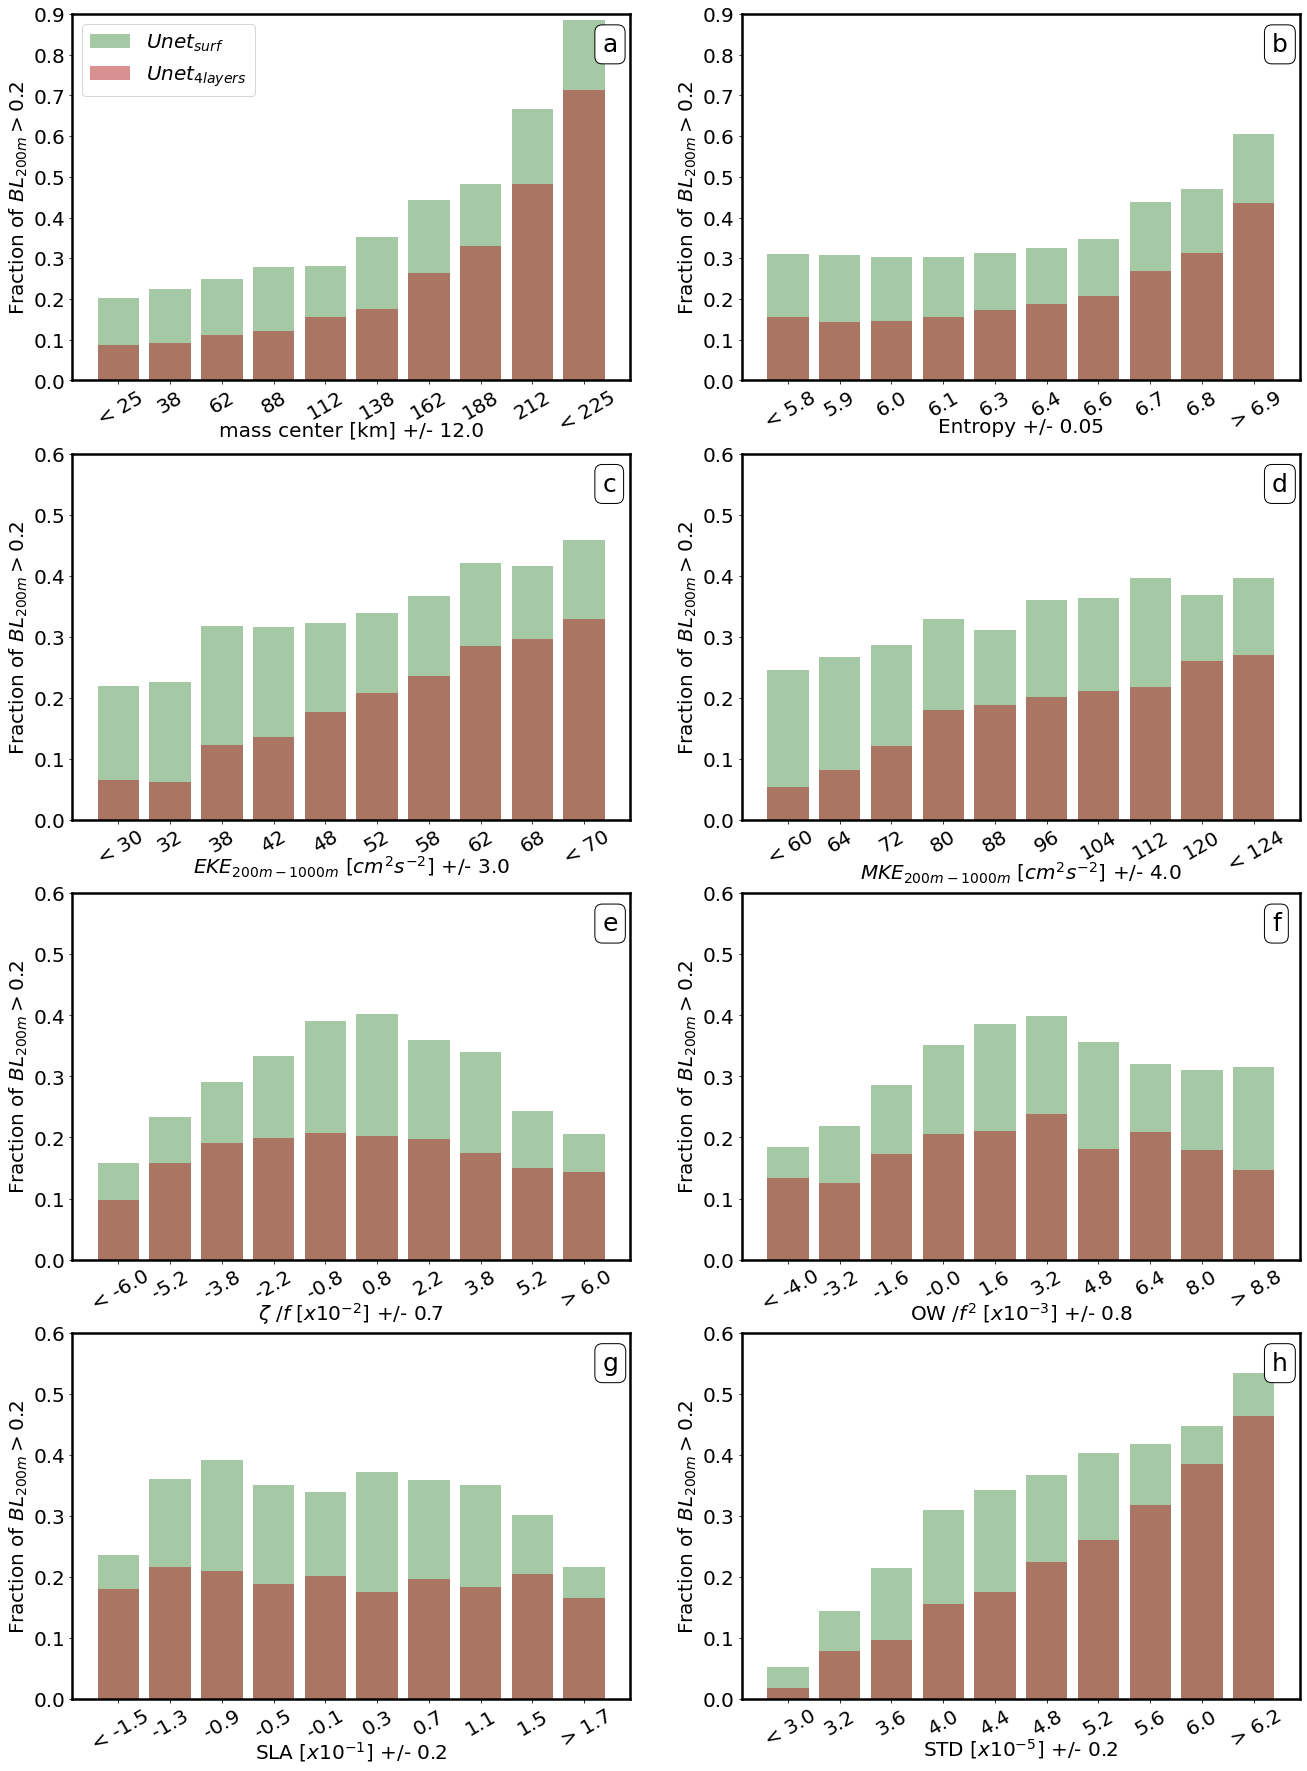

In [9]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50
props = dict(boxstyle='round', facecolor='white', alpha=1)

fig = plt.figure(figsize=(22,31))

nb_y = 4
nb_x = 2 


ax = fig.add_subplot(nb_y,nb_x,6)
plot_bar_chart(list_xticks_ow,nv_ow,nv_ow_4L,nb_ow,'ow',ax)
textstr = str('f')
plt.text(.95, .95, textstr, ha='left', va='top', transform=ax.transAxes,bbox=props,size=25)

ax = fig.add_subplot(nb_y,nb_x,5)
plot_bar_chart(list_xticks_vrt,nv_vrt,nv_vrt_4L,nb_vrt,'vrt',ax)
textstr = str('e')
plt.text(.95, .95, textstr, ha='left', va='top', transform=ax.transAxes,bbox=props,size=25)

ax = fig.add_subplot(nb_y,nb_x,7)
plot_bar_chart(list_xticks_sla_4L,nv_sla,nv_sla_4L,nb_sla,'sla',ax)
textstr = str('g')
plt.text(.95, .95, textstr, ha='left', va='top', transform=ax.transAxes,bbox=props,size=25)

# PDF and model charact
ax = fig.add_subplot(nb_y,nb_x,1)
plot_bar_chart(list_xticks_mc,nv_mc,nv_mc_4L,nb_mc,'pdf_mc',ax)
textstr = str('a')
plt.text(.95, .95, textstr, ha='left', va='top', transform=ax.transAxes,bbox=props,size=25)

ax = fig.add_subplot(nb_y,nb_x,2)
plot_bar_chart(list_xticks_entro,nv_entro,nv_entro_4L,nb_entro,'entropie',ax)
textstr = str('b')
plt.text(.95, .95, textstr, ha='left', va='top', transform=ax.transAxes,bbox=props,size=25)

ax = fig.add_subplot(nb_y,nb_x,8)
plot_bar_chart(list_xticks_std,nv_std,nv_std_4L,nb_std,'pdf_std',ax)
textstr = str('h')
plt.text(.95, .95, textstr, ha='left', va='top', transform=ax.transAxes,bbox=props,size=25)

ax = fig.add_subplot(nb_y,nb_x,3)
plot_bar_chart(list_xticks_eke,nv_eke,nv_eke_4L,nb_eke,'eke',ax)
textstr = str('c')
plt.text(.95, .95, textstr, ha='left', va='top', transform=ax.transAxes,bbox=props,size=25)

ax = fig.add_subplot(nb_y,nb_x,4)
plot_bar_chart(list_xticks_kebar,nv_kebar,nv_kebar_4L,nb_kebar,'mke',ax)
textstr = str('d')
plt.text(.95, .95, textstr, ha='left', va='top', transform=ax.transAxes,bbox=props,size=25)

#plt.savefig('influence_score_entropie.png',dpi=400)

# VRT / OW / KE analyse

In [10]:
vrt = vrt_mean[:-36]
strain = strain_mean[:-36] 
index_valid = np.argwhere(list_bhatta_surf < 0.2)
index_nonvalid = np.argwhere(list_bhatta_surf > 0.2)

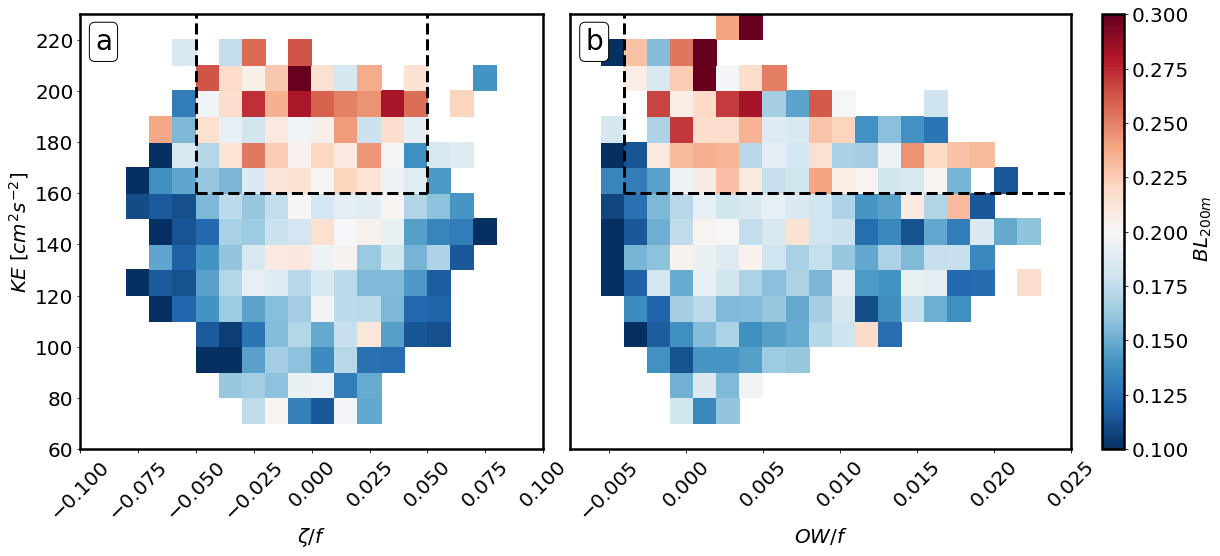

In [11]:
import scipy.stats as st
from matplotlib.gridspec import GridSpec
import matplotlib.transforms as mtransforms

fig = plt.figure(figsize=(20,8))


gs = GridSpec(1, 7, figure=fig)

ax = fig.add_subplot(gs[0, :3])

label = 'a'
trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
ax.text(0.01, 0.98, label, transform=ax.transAxes + trans,
        fontsize=28, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=1, pad=0.2))

dx = 0.01
dy = 10
binx = np.arange(-0.10,.10+dx,dx)
biny = np.arange(50,250+dy,dy)
#JPDF conditionned w
vrt_ke_bin, xedges, yedges, _ = st.binned_statistic_2d(vrt_mean[:-36],(KEbar_pos+EKE_pos)*10000,list_bhatta_surf,\
'mean', bins=[binx, biny])
vrt_ke_bin = np.rot90(vrt_ke_bin); vrt_ke_bin = np.flipud(vrt_ke_bin)

vrt_count, xedges, yedges, _ = st.binned_statistic_2d(vrt_mean[:-36],(KEbar_pos+EKE_pos)*10000,list_bhatta_surf,\
'count', bins=[binx, biny])
vrt_count = np.rot90(vrt_count); vrt_count = np.flipud(vrt_count)

vrt_ke_bin = np.where(vrt_count > 5,vrt_ke_bin, np.nan)

plt.pcolormesh(xedges,yedges,vrt_ke_bin,cmap=plt.cm.RdBu_r,vmin=0.1,vmax=0.3)
plt.xlabel("$\zeta/f$",size=20)
plt.ylabel("$KE$ $[cm^2 s^{-2}]$",size=20)


plt.vlines(-.05,160,250,linestyle='--',color='k',linewidth=3)
plt.vlines(.05,160,250,linestyle='--',color='k',linewidth=3)
plt.hlines(160,-.05,.05,linestyle='--',color='k',linewidth=3)
plt.ylim(60,230)
plt.xticks(size=20,rotation=45)
plt.yticks(size=20)

# SECOND 

ax = fig.add_subplot(gs[0, 3:])

label = 'b'
trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
ax.text(0.01, 0.98, label, transform=ax.transAxes + trans,
        fontsize=28, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=1, pad=0.2))

dx = 0.0015
dy = 10
binx = np.arange(-0.01,.025+dx,dx)
biny = np.arange(50,250+dy,dy)
#JPDF conditionned w
ow_ke_bin, xedges, yedges, _ = st.binned_statistic_2d(ow_mean[:-36],(KEbar_pos+EKE_pos)*10000,list_bhatta_surf,\
'mean', bins=[binx, biny])
ow_ke_bin = np.rot90(ow_ke_bin); ow_ke_bin = np.flipud(ow_ke_bin)

ow_count, xedges, yedges, _ = st.binned_statistic_2d(ow_mean[:-36],(KEbar_pos+EKE_pos)*10000,list_bhatta_surf,\
'count', bins=[binx, biny])
ow_count = np.rot90(ow_count); ow_count = np.flipud(ow_count)

ow_ke_bin = np.where(ow_count > 5,ow_ke_bin, np.nan)

plt.pcolormesh(xedges,yedges,ow_ke_bin,cmap=plt.cm.RdBu_r,vmin=0.1,vmax=0.3)

plt.xlabel("$OW/f$",size=20)
#plt.ylabel("$KE$")
plt.vlines(-0.004,160,250,linestyle='--',color='k',linewidth=3)
plt.hlines(160,-0.004,0.025,linestyle='--',color='k',linewidth=3)
plt.xticks(size=20,rotation=45)
plt.yticks([],size=20)
plt.ylim(60,230)
plt.xlim(-0.0075,.025)


cb = plt.colorbar()
cb.set_label(r' $BL_{200m}$', fontsize=20)
cb.ax.tick_params(labelsize=20)

dir_save = "../Figures/"
#plt.savefig(dir_save+"KE_vs_vrt_and_OW.png",dpi=400,bbox_inches='tight')